# Intro to Ray Serve

This notebook will introduce you to Ray Serve, a framework for building and deploying scalable ML applications.

<div class="alert alert-block alert-info">
    
<b>Here is the roadmap for this notebook:</b>

<ul>
    <li><b>Part 1:</b> Overview of Ray Serve</li>
    <li><b>Part 2:</b> Implement an MNISTClassifier service</li>
    <li><b>Part 3:</b> Advanced features of Ray Serve</li>
    <li><b>Part 4:</b> Ray Serve in Production</li>
</ul>
</div>


## Imports

In [1]:
from typing import Any
from torchvision import transforms

import json
import numpy as np
import ray
import requests
import torch
from ray import serve
from matplotlib import pyplot as plt
from fastapi import FastAPI
from starlette.requests import Request

## 1. Overview of Ray Serve

Serve is a framework for serving ML applications. 

Here is a high-level overview of the architecture of a Ray Serve Application.

<img src='https://technical-training-assets.s3.us-west-2.amazonaws.com/Ray_Serve/serve_architecture.png' width=700/>

An Application is a collection of one or more Deployments that are deployed together.

### Deployments

`Deployment` is the fundamental developer-facing element of serve.

<img src='https://technical-training-assets.s3.us-west-2.amazonaws.com/Ray_Serve/deployment.png' width=600/>

Each deployment can have multiple replicas. 

A replica is implemented as a Ray actor with a queue to process incoming requests.

Each replica can be configured with a set of compute resources. 

### When to use Ray Serve?

Ray Serve is designed to be used in the following scenarios:
- Build end-to-end ML applications with a flexible and programmable python API
- Flexibly scale up and down your compute resources to meet the demand of your application
- Easy to develop on a local machine, and scale to a multi-node GPU cluster

#### Key Ray Serve Features
Ray Serve provides the following key features and optimizations:
- [response streaming](https://docs.ray.io/en/latest/serve/tutorials/streaming.html)
- [dynamic request batching](https://docs.ray.io/en/latest/serve/advanced-guides/dyn-req-batch.html)
- [multi-node/multi-GPU serving](https://docs.ray.io/en/latest/serve/tutorials/vllm-example.html)
- [model multiplexing](https://docs.ray.io/en/latest/serve/model-multiplexing.html)
- [fractional compute resource usage](https://docs.ray.io/en/latest/serve/configure-serve-deployment.html)

## 2. Implement an MNISTClassifier service

Let’s jump right in and get a simple ML service up and running on Ray Serve. 

Recall the `MNISTClassifier` we built to perform batch inference on the `MNIST` dataset.

In [2]:
class OfflineMNISTClassifier:
    def __init__(self, local_path: str):
        self.model = torch.jit.load(local_path)
        self.model.to("cuda")
        self.model.eval()

    def __call__(self, batch: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
        return self.predict(batch)
    
    def predict(self, batch: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
        images = torch.tensor(batch["image"]).float().to("cuda")

        with torch.no_grad():
            logits = self.model(images).cpu().numpy()

        batch["predicted_label"] = np.argmax(logits, axis=1)
        return batch

In [3]:
# We download the model from s3 to the EFS storage
!aws s3 cp s3://anyscale-public-materials/ray-ai-libraries/mnist/model/model.pt /mnt/cluster_storage/model.pt

download: s3://anyscale-public-materials/ray-ai-libraries/mnist/model/model.pt to ../../../mnt/cluster_storage/model.pt


Here is how we can use the `OfflineMNISTClassifier` to perform batch inference on a dataset of random images.

In [4]:
# Create a dataset of random images
ds = ray.data.from_items([{"image": np.random.rand(1, 28, 28)} for _ in range(100)])

# Map the OfflineMNISTClassifier to the dataset
ds = ds.map_batches(
    OfflineMNISTClassifier,
    fn_constructor_kwargs={"local_path": "/mnt/cluster_storage/model.pt"},
    concurrency=1,
    num_gpus=1,
    batch_size=10
)

# Take a look at the first 10 predictions
ds.take_batch(10)["predicted_label"]

2026-02-11 03:21:09,882	INFO worker.py:1596 -- Connecting to existing Ray cluster at address: 100.92.97.41:6379...
2026-02-11 03:21:09,889	INFO worker.py:1772 -- Connected to Ray cluster. View the dashboard at https://session-hxu6nh6hwtp5aam8r7sg1q2zbh.i.anyscaleuserdata.com 
2026-02-11 03:21:09,892	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_cb80246efcb2c1ce0430fc7d0dbd541bfd29db66.zip' (0.14MiB) to Ray cluster...
2026-02-11 03:21:09,893	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_cb80246efcb2c1ce0430fc7d0dbd541bfd29db66.zip'.
2026-02-11 03:21:11,488	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-02-11_03-06-48_733370_2567/logs/ray-data
2026-02-11 03:21:11,489	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(OfflineMNISTClassifier)] -> LimitOperator[limit=10]


- MapBatches(OfflineMNISTClassifier) 1: 0 bundle [00:00, ? bundle/s]

- limit=10 2: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

array([6, 6, 1, 6, 6, 1, 1, 1, 6, 6])

Now, if want to migrate to an online inference setting, we can transform this into a Ray Serve Deployment by applying the `@serve.deployment` decorator 


In [5]:
@serve.deployment() # this is the decorator to add
class OnlineMNISTClassifier:
    def __init__(self, local_path: str):
        self.model = torch.jit.load(local_path)
        self.model.to("cuda")
        self.model.eval()

    async def __call__(self, request: Request) -> dict[str, Any]: # __call__ now takes a Starlette Request object
        batch = json.loads(await request.json()) # we will need to parse the JSON body of the request
        return await self.predict(batch)
    
    async def predict(self, batch: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
        # same code as OfflineMNISTClassifier.predict except we added async to the method
        images = torch.tensor(batch["image"]).float().to("cuda")

        with torch.no_grad():
            logits = self.model(images).cpu().numpy()

        batch["predicted_label"] = np.argmax(logits, axis=1)
        return batch

(raylet, ip=100.107.164.125) {"asctime":"2026-02-11 03:21:16,897","levelname":"E","message":"Failed to send wait complete: RpcError: RPC Error message: recvmsg:Connection reset by peer; RPC Error details: ","component":"raylet","filename":"worker.cc","lineno":176}
(ServeController pid=6134) INFO 2026-02-11 03:21:17,477 controller 6134 deployment_state.py:1598 - Deploying new version of Deployment(name='OnlineMNISTClassifier', app='mnist_classifier') (initial target replicas: 1).
(ServeController pid=6134) INFO 2026-02-11 03:21:17,584 controller 6134 deployment_state.py:1721 - Stopping 1 replicas of Deployment(name='OnlineMNISTClassifier', app='mnist_classifier') with outdated versions.
(ServeController pid=6134) INFO 2026-02-11 03:21:17,584 controller 6134 deployment_state.py:1844 - Adding 1 replica to Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
(ServeController pid=6134) INFO 2026-02-11 03:21:19,686 controller 6134 deployment_state.py:2182 - Replica(id='cn9jccvq'

2026-02-11 03:21:17,004	WARNING api.py:346 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2026-02-11 03:21:17,005	WARNING api.py:397 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.


We can now instantiate the `OnlineMNISTClassifier` as a Ray Serve Application using `.bind`.

In [6]:
mnist_deployment = OnlineMNISTClassifier.options(
    num_replicas=1,
    ray_actor_options={"num_gpus": 1},
)

mnist_app = mnist_deployment.bind(local_path="/mnt/cluster_storage/model.pt")

<div class="alert alert-block alert-warning">

**Note:** `.bind` is a method that takes in the arguments to pass to the Deployment constructor.

</div>


We can then run the application 

In [7]:
mnist_deployment_handle = serve.run(mnist_app, name='mnist_classifier', blocking=False)

2026-02-11 03:21:17,396	INFO handle.py:126 -- Created DeploymentHandle 'x7zzlhjc' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:17,396	INFO handle.py:126 -- Created DeploymentHandle '2lh219o5' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:22,418	INFO handle.py:126 -- Created DeploymentHandle 'mnetj98k' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:22,419	INFO api.py:574 -- Deployed app 'mnist_classifier' successfully.


We can test it as an HTTP endpoint

In [8]:
images = np.random.rand(2, 1, 28, 28).tolist()
json_request = json.dumps({"image": images})
response = requests.post("http://localhost:8000/", json=json_request)
response.json()["predicted_label"]

[1, 1]

We can also test it as a gRPC endpoint

In [9]:
batch = {"image": np.random.rand(10, 1, 28, 28)}
response = await mnist_deployment_handle.predict.remote(batch)
response["predicted_label"]

2026-02-11 03:21:23,163	INFO handle.py:126 -- Created DeploymentHandle 'yn4s5xty' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:23,175	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier'): {'5k311kf1'}.


array([1, 1, 1, 6, 6, 6, 1, 6, 6, 1])

## 3. Advanced features of Ray Serve

### Using fractions of a GPU

With Ray we can specify fractional compute resources for each deployment's replica. 

This is useful to help us fully utilize a GPU especially when running small models like our `MNISTClassifier` model.

Here is how to specify only 10% of a GPU's compute resources for our `MNISTClassifier` model.

In [10]:
mnist_app = OnlineMNISTClassifier.options(
    num_replicas=4, # we can scale to up to 10 replicas on a single GPU
    ray_actor_options={"num_gpus": 0.1}, 
).bind(local_path="/mnt/cluster_storage/model.pt")

Next we update the running application by running serve.run with the new options.

In [11]:
mnist_deployment_handle = serve.run(mnist_app, name='mnist_classifier', blocking=False)

2026-02-11 03:21:23,677	INFO handle.py:126 -- Created DeploymentHandle 'pv7j8vw1' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:23,678	INFO handle.py:126 -- Created DeploymentHandle '8tiwxt6n' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:32,708	INFO api.py:574 -- Deployed app 'mnist_classifier' successfully.


2026-02-11 03:21:28,431	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier'): {'vmiobkaw', 'uetpechr', 'cf8ih81t'}.
2026-02-11 03:21:32,364	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier'): {'vmiobkaw', 'uetpechr', 'cf8ih81t', 'g0wmdqaf'}.
2026-02-11 03:21:34,229	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier'): set().
2026-02-11 03:22:32,945	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor'): {'05gypz71'}.
2026-02-11 03:22:33,208	INFO pow_2_scheduler.py:260 -- Got updated replicas for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor'): set().


We can test the new application by sending a sample request.

In [12]:
images = np.random.rand(2, 1, 28, 28).tolist()
json_request = json.dumps({"image": images})
response = requests.post("http://localhost:8000/", json=json_request)
response.json()["predicted_label"]

[6, 6]

### Customizing autoscaling

Ray Serve provides a simple way to autoscale the number of replicas in a deployment. It is primarily based on the target number of ongoing requests per replica.

i.e. here is how we can set the autoscaling config for our `OnlineMNISTClassifier` deployment.

In [13]:
mnist_app = OnlineMNISTClassifier.options(
    ray_actor_options={"num_gpus": 0.1}, 
    autoscaling_config={
        "target_ongoing_requests": 10,
    },
).bind(local_path="/mnt/cluster_storage/model.pt")

We can also control more granularly the autoscaling logic by setting:
- the upscale and downscale delays
- the intervals at which the replica sends metrics reports about the current number of ongoing requests
- the look-back period used to evaluate the current number of ongoing requests

Here is an example of how to set these options:

In [14]:
mnist_app = OnlineMNISTClassifier.options(
    ray_actor_options={"num_gpus": 0.1}, 
    autoscaling_config={
        "target_ongoing_requests": 10,
        "upscale_delay_s": 10,
        "downscale_delay_s": 10,
        "metrics_interval_s": 10,
        "look_back_period_s": 10, 
    },
).bind(local_path="/mnt/cluster_storage/model.pt")

We can additionally control the minimum and maximum number of replicas that can be scaled up and down. 

We can even specify to start scaling up from 0 replicas.

In [15]:
mnist_app = OnlineMNISTClassifier.options(
    ray_actor_options={"num_gpus": 0.1}, 
    autoscaling_config={
        "target_ongoing_requests": 10,
        "initial_replicas": 0, # scale up from 0 replicas
        "min_replicas": 0,
        "max_replicas": 10,
        # extreme upscale speeds
        "upscale_delay_s": 0,
        "metrics_interval_s": 0.1,
        "look_back_period_s": 0.1,
    },
).bind(local_path="/mnt/cluster_storage/model.pt")

Let's run the application with the new autoscaling config.

In [16]:
mnist_deployment_handle = serve.run(mnist_app, name='mnist_classifier', blocking=False)

2026-02-11 03:21:34,050	INFO handle.py:126 -- Created DeploymentHandle 'qm116n27' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:34,051	INFO handle.py:126 -- Created DeploymentHandle 'jqasd0j3' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:37,067	INFO api.py:574 -- Deployed app 'mnist_classifier' successfully.


Looking at the Ray Serve dashboard, we can see we are currently at 0 replicas - i.e. no GPU resources are being used.

<img src='https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/autoscaling_at_0.png' width=700/>

We can send out a larger number of requests to the `OnlineMNISTClassifier` deployment to see the autoscaling in action.

In [17]:
batch = {"image": np.random.rand(10, 1, 28, 28)}
[
    mnist_deployment_handle.predict.remote(batch)
    for _ in range(100)
]

2026-02-11 03:21:37,305	INFO handle.py:126 -- Created DeploymentHandle 'weo0eq66' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:37,306	INFO handle.py:126 -- Created DeploymentHandle 'zxcvztp0' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:37,308	INFO handle.py:126 -- Created DeploymentHandle 'hm8mz6it' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:37,310	INFO handle.py:126 -- Created DeploymentHandle '4p072ccd' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:37,311	INFO handle.py:126 -- Created DeploymentHandle '3q39fsb6' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:37,312	INFO handle.py:126 -- Created DeploymentHandle 'andi3qih' for Deployment(name='OnlineMNISTClassifier', app='mnist_classifier').
2026-02-11 03:21:37,315	INFO handle.py:126 -- Created DeploymentHandle 'i59pu2lk' for De

Looking at the Ray Serve dashboard, we can see that the number of replicas has scaled up to 10 as expected.

<img src='https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/autoscaling_at_10.png' width=700/>

Let's shutdown the service for now.

In [18]:
serve.shutdown()

### Composing Deployments

Ray Serve allows us to compose Deployments together to build more complex applications.

Lets compose our `OnlineMNISTClassifier` with an `OnlineMNISTPreprocessor` deployment that performs the necessary transformations on the input data.


In [19]:
@serve.deployment
class OnlineMNISTPreprocessor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
    async def run(self, batch: dict[str, Any]) -> dict[str, Any]:
        images = batch["image"]
        images = [self.transform(np.array(image, dtype=np.uint8)).cpu().numpy() for image in images]
        return {"image": images}

preprocessor_app = OnlineMNISTPreprocessor.bind()

2026-02-11 03:21:42,125	WARNING api.py:346 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2026-02-11 03:21:42,126	WARNING api.py:397 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.


In [20]:
preprocessor_handle = serve.run(preprocessor_app, name='mnist_preprocessor', blocking=False, route_prefix="/preprocess")

2026-02-11 03:21:46,391	INFO handle.py:126 -- Created DeploymentHandle 'zj6oxm8y' for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor').
2026-02-11 03:21:46,391	INFO handle.py:126 -- Created DeploymentHandle 'if3r78gk' for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor').
2026-02-11 03:21:51,409	INFO handle.py:126 -- Created DeploymentHandle 'gslhgqm5' for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor').
2026-02-11 03:21:51,410	INFO api.py:574 -- Deployed app 'mnist_preprocessor' successfully.


Let's load an image and pass it to the `ImageTransformDeployment`

In [21]:
ds = ray.data.read_images("s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/", include_paths=True)
image_batch = ds.take_batch(10)

2026-02-11 03:22:19,643	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-02-11_03-06-48_733370_2567/logs/ray-data
2026-02-11 03:22:19,644	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ExpandPaths] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=10]


- ExpandPaths 1: 0 bundle [00:00, ? bundle/s]

- ReadFiles 2: 0 bundle [00:00, ? bundle/s]

- limit=10 3: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

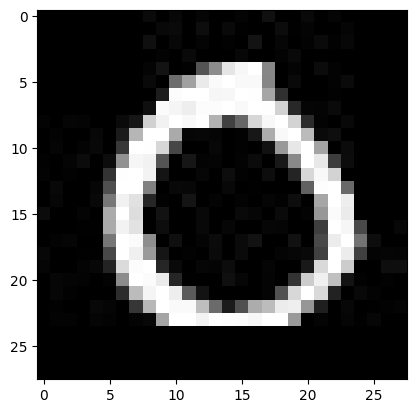

In [22]:
# plot the first image using matplotlib
plt.imshow(image_batch["image"][0], cmap="gray")
plt.show()

In [23]:
normalized_batch = await preprocessor_handle.run.remote(image_batch)

for image in normalized_batch["image"]:
    assert image.shape == (1, 28, 28) # channel, height, width
    assert image.min() >= -1 and image.max() <= 1 # normalized to [-1, 1]

2026-02-11 03:22:32,940	INFO handle.py:126 -- Created DeploymentHandle '4ycthc8q' for Deployment(name='OnlineMNISTPreprocessor', app='mnist_preprocessor').


We will proceed to shutdown the preprocessor application to prove it will be automatically created by the ingress.


In [24]:
serve.shutdown()

Let's now build an ingress for our application that composes the `ImageTransformDeployment` and `OnlineMNISTClassifier`

In [25]:
@serve.deployment
class ImageServiceIngress:
    def __init__(self, preprocessor: OnlineMNISTPreprocessor, model: OnlineMNISTClassifier):
        self.preprocessor = preprocessor
        self.model = model

    async def __call__(self, request: Request):
        batch = json.loads(await request.json())
        response = await self.preprocessor.run.remote(batch)
        return await self.model.predict.remote(response)

2026-02-11 03:22:36,102	WARNING api.py:346 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2026-02-11 03:22:36,103	WARNING api.py:397 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.


In [26]:
image_classifier_ingress = ImageServiceIngress.bind(
    preprocessor=OnlineMNISTPreprocessor.bind(),
    model=OnlineMNISTClassifier.options(
        num_replicas=1,
        ray_actor_options={"num_gpus": 0.1},
    ).bind(local_path="/mnt/cluster_storage/model.pt"),
)

handle = serve.run(image_classifier_ingress, name='image_classifier', blocking=False)

2026-02-11 03:22:40,200	INFO handle.py:126 -- Created DeploymentHandle 'pnhxf3zt' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2026-02-11 03:22:40,205	INFO handle.py:126 -- Created DeploymentHandle 'tgkubmdx' for Deployment(name='OnlineMNISTClassifier', app='image_classifier').
2026-02-11 03:22:40,206	INFO handle.py:126 -- Created DeploymentHandle '0tlduqzc' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2026-02-11 03:22:40,206	INFO handle.py:126 -- Created DeploymentHandle '3g3q6u0o' for Deployment(name='OnlineMNISTClassifier', app='image_classifier').
2026-02-11 03:22:40,213	INFO handle.py:126 -- Created DeploymentHandle 'hye2wsr1' for Deployment(name='ImageServiceIngress', app='image_classifier').
2026-02-11 03:22:40,214	INFO handle.py:126 -- Created DeploymentHandle 'qkejh7we' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2026-02-11 03:22:40,214	INFO handle.py:126 -- Created DeploymentHandle 'udwsxyuk' fo

Let's test the application by sending a sample HTTP request to our ingress endpoint.


In [27]:
json_request = json.dumps({"image": image_batch["image"].tolist()}) 
response = requests.post("http://localhost:8000/", json=json_request)
response.json()["predicted_label"]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Integrating with FastAPI

Ray Serve can be integrated with FastAPI to provide:
- HTTP routing
- Pydantic model validation
- OpenAPI documentation

To integrate a Deployment with FastAPI, we can use the `@serve.ingress` decorator to designate a FastAPI app as the entrypoint for HTTP requests to our Serve application.

In [28]:
app = FastAPI()

@serve.deployment
@serve.ingress(app)
class ImageServiceIngress:
    def __init__(self, preprocessor: OnlineMNISTPreprocessor, model: OnlineMNISTClassifier):
        self.preprocessor = preprocessor
        self.model = model
    
    @app.post("/predict")
    async def predict(self, request: Request):
        batch = json.loads(await request.json())
        response = await self.preprocessor.run.remote(batch)
        out = await self.model.predict.remote(response)
        return {"predicted_label": out["predicted_label"].tolist()}

2026-02-11 03:22:47,285	WARNING api.py:346 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2026-02-11 03:22:47,286	WARNING api.py:397 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.


We now can build the application and run it.

In [29]:
image_classifier_ingress = ImageServiceIngress.bind(
    preprocessor=OnlineMNISTPreprocessor.bind(),
    model=OnlineMNISTClassifier.options(
        num_replicas=1,
        ray_actor_options={"num_gpus": 0.1},
    ).bind(local_path="/mnt/cluster_storage/model.pt"),
)

handle = serve.run(image_classifier_ingress, name='image_classifier', blocking=False)

2026-02-11 03:22:47,564	INFO handle.py:126 -- Created DeploymentHandle 'rvfltlzz' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2026-02-11 03:22:47,569	INFO handle.py:126 -- Created DeploymentHandle 'unzfeidh' for Deployment(name='OnlineMNISTClassifier', app='image_classifier').
2026-02-11 03:22:47,570	INFO handle.py:126 -- Created DeploymentHandle 'mmosnuw1' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2026-02-11 03:22:47,571	INFO handle.py:126 -- Created DeploymentHandle 'vhkqzs59' for Deployment(name='OnlineMNISTClassifier', app='image_classifier').
2026-02-11 03:22:47,580	INFO handle.py:126 -- Created DeploymentHandle 'bbooxaw2' for Deployment(name='ImageServiceIngress', app='image_classifier').
2026-02-11 03:22:47,581	INFO handle.py:126 -- Created DeploymentHandle 'yavuuhha' for Deployment(name='OnlineMNISTPreprocessor', app='image_classifier').
2026-02-11 03:22:47,581	INFO handle.py:126 -- Created DeploymentHandle 'kt1ewiyw' fo

After running the application, we can get test it as an HTTP endpoint programmatically.

In [30]:
json_request = json.dumps({"image": image_batch["image"].tolist()}) 
response = requests.post("http://localhost:8000/predict", json=json_request)
response.json()["predicted_label"]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We can also visit the auto-generated FastAPI docs at http://localhost:8000/docs to get an interactive UI to test our endpoint.

## 4. Ray Serve in Production

1. Klaviyo built their model serving platform with Ray Serve. See [this article from Klaviyo Engineering](https://klaviyo.tech/how-klaviyo-built-a-robust-model-serving-platform-with-ray-serve-c02ec65788b3)
2. Samsara uses Ray Serve to bridge the gap of development to deployment of their models. See [this article from Samsara Engineering](https://www.samsara.com/blog/building-a-modern-machine-learning-platform-with-ray)

## Clean up 

Let's shutdown the application and clean up the resources we created.

In [31]:
serve.shutdown()
!rm -rf /mnt/cluster_storage/model.pt